In [1]:
import logging

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from custom_losses import *
from custom_metrics import *
from preprocessing import *
from models import build_unet, build_w_net
import os
import cv2
from PIL import Image


In [2]:
logging.getLogger().setLevel(logging.WARNING)

In [3]:
# Define paths to your dataset
image_folder = 'DRIVE/training/images'
label_folder = 'DRIVE/training/manual'
mask_folder = 'DRIVE/training/mask'
test_image_folder = 'DRIVE/test/images'
test_label_folder = 'DRIVE/test/manual'
test_mask_folder = 'DRIVE/training/mask'
# Get list of all files in the image and label directories
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))
mask_files = sorted(os.listdir(mask_folder))
test_image_files = sorted(os.listdir(test_image_folder))
test_label_files = sorted(os.listdir(test_label_folder))
test_mask_files = sorted(os.listdir(test_mask_folder))

In [4]:
# Function to preprocess images and labels
def preprocess(image_path, label_path, mask_path):
    # Convert the TensorFlow Tensor object to a string
    image_path = image_path.decode('utf-8')
    label_path = label_path.decode('utf-8')
    mask_path = mask_path.decode('utf-8')
    # Load image and label
    image = cv2.imread(image_path)[..., 1]
    try:
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if label is None or mask is None:
            raise FileNotFoundError
    except FileNotFoundError:
        lb = Image.open(label_path)
        lb.seek(lb.tell())
        label = np.array(lb)
        mask = Image.open(mask_path)
        mask.seek(mask.tell())
        mask = np.array(mask)
    # Resize images and labels
    input = ResizePreprocessor(512, 512)
    x = CLAHE()(input)
    x = MedianBlurPreprocessor()(x)
    x = GammaCorrectionPreprocessor()(x)
    x = MultiScaleMorphologicalPreprocessor(
        operation='open',  # Options: 'dilate', 'erode', 'open', 'close'
        kernel_sizes=[3, 5, 7],
        kernel_shape=cv2.MORPH_RECT,
        iterations=1
    )(x)
    NormalizePreprocessor()(x)
    for_labels = ResizePreprocessor(512, 512)
    NormalizePreprocessor()(for_labels)
    image = input.process(image)[:, :, np.newaxis].astype('float32')
    label = for_labels.process(label)[:, :, np.newaxis].astype('float32')
    mask = for_labels.process(mask)[:, :, np.newaxis].astype('float32')
    image *= mask
    label *= mask
    return image, label



In [5]:
# Function to load the dataset into tf.data.Dataset
def load_dataset(image_folder,image_files, label_folder, label_files, mask_folder, mask_files):
    # Create file paths
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    label_paths = [os.path.join(label_folder, f) for f in label_files]
    mask_paths = [os.path.join(mask_folder, f) for f in mask_files]
    # Create a TensorFlow dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths, mask_paths))
    
    # Map the preprocessing function to each element in the dataset
    dataset = dataset.map(lambda img_path, lbl_path, m_path: tf.numpy_function(
                          func=preprocess, inp=[img_path, lbl_path, m_path], 
                          Tout=[tf.float32, tf.float32]))
    
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(4)  # Set batch size to 32, modify as needed
    
    return dataset



In [6]:
# Load the dataset
dataset = load_dataset(image_folder, image_files, label_folder, label_files, mask_folder, mask_files)
test_dataset= load_dataset(test_image_folder, test_image_files, test_label_folder, test_label_files, test_mask_folder, test_mask_files)

In [7]:
for image, label in dataset:
    print(label)

tf.Tensor(
[[[[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  ...

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  ...

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.

In [8]:
num_epoch = 4000
step = 50
# Define the cosine annealing learning rate scheduler
def cosine_annealing_schedule(epoch, lr):
    initial_lr = lr  # Use the current learning rate as the initial rate
    if lr%step == 0:
        lr = 0.5 * initial_lr * (1 + np.cos(np.pi * (epoch) / num_epoch))
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(cosine_annealing_schedule)

In [7]:
wnet = build_w_net((512, 512, 1))  # Input size is 128x128 grayscale image
wnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [8]:

wnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1E-3), loss={"out1":DiceLoss(), "out2":DiceLoss()}, metrics=[iou_metric])


In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
wnet.fit(x=dataset, epochs=200, verbose=2, callbacks=[early_stopping], validation_data=test_dataset)

Epoch 1/200
5/5 - 13s - loss: 1.5059 - out1_loss: 0.7479 - out2_loss: 0.7580 - out1_iou_metric: 0.0883 - out2_iou_metric: 0.0931 - val_loss: 1.9975 - val_out1_loss: 0.9987 - val_out2_loss: 0.9988 - val_out1_iou_metric: 3.1398e-04 - val_out2_iou_metric: 3.1443e-04 - 13s/epoch - 3s/step
Epoch 2/200
5/5 - 3s - loss: 1.3376 - out1_loss: 0.6750 - out2_loss: 0.6627 - out1_iou_metric: 0.1170 - out2_iou_metric: 0.1359 - val_loss: 1.9975 - val_out1_loss: 0.9987 - val_out2_loss: 0.9988 - val_out1_iou_metric: 3.1530e-04 - val_out2_iou_metric: 3.1552e-04 - 3s/epoch - 531ms/step
Epoch 3/200
5/5 - 3s - loss: 1.2279 - out1_loss: 0.6081 - out2_loss: 0.6198 - out1_iou_metric: 0.1426 - out2_iou_metric: 0.1583 - val_loss: 1.9975 - val_out1_loss: 0.9986 - val_out2_loss: 0.9989 - val_out1_iou_metric: 3.1652e-04 - val_out2_iou_metric: 3.1723e-04 - 3s/epoch - 529ms/step
Epoch 4/200
5/5 - 3s - loss: 1.1520 - out1_loss: 0.5657 - out2_loss: 0.5863 - out1_iou_metric: 0.1601 - out2_iou_metric: 0.1690 - val_loss: 

KeyboardInterrupt: 

In [21]:
for batch in dataset:
    image, label = batch
    pl = wnet.predict(image)
    

1/1 [==============================] - 0s 31ms/step


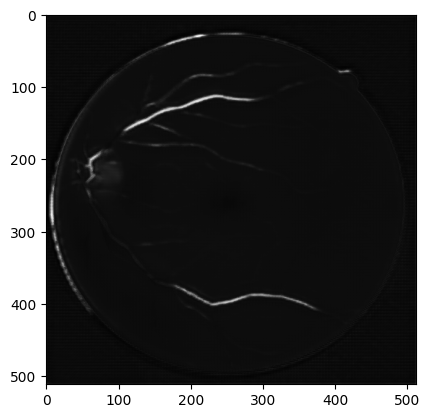